# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [1]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-8ys7irbo
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-8ys7irbo
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [ ]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/drive/MyDrive/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


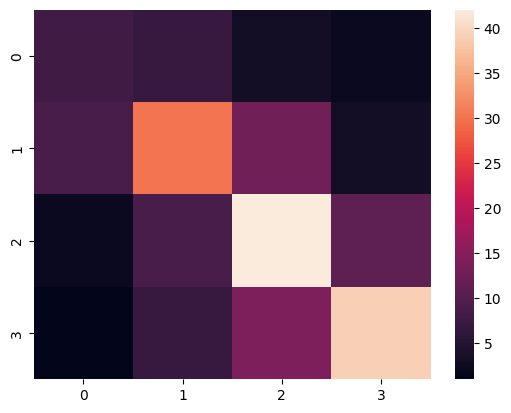

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


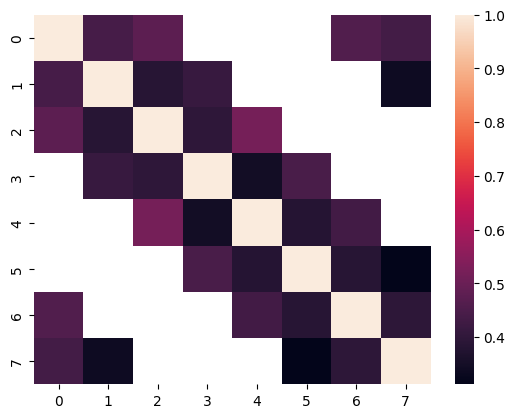

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

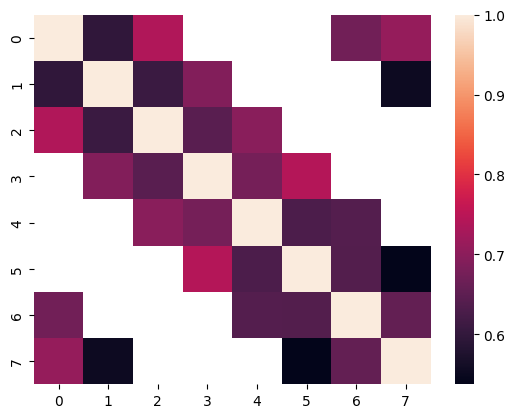

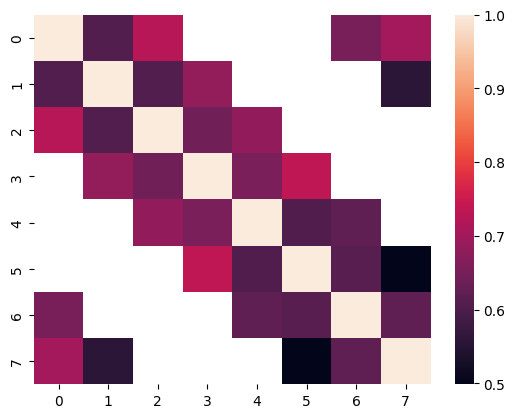

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
news_df = pandas.read_excel('/content/drive/MyDrive/eda_processed_data.xlsx')
news_df.head()

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,服务,企业,美国,国家,文化,生活,whether_layout_1,a1,a2,a3
0,0,9,合作是中美双方最好的选择,2.0,要闻,2019-01-01,新华社北京1月1日电2019年1月1日，国家主席习近平与美国总统特朗普互致贺信，热烈祝贺两国...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,371.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '美国', '...",...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0
1,1,10,习近平和普京互致新年贺电,2.0,要闻,2019-01-01,新华社北京12月31日电2018年12月31日，国家主席习近平和俄罗斯总统普京互致新年贺电。...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,659.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '俄罗斯', ...",...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0
2,2,11,元旦献词,2.0,要闻,2019-01-01,上海市市长应勇2019年1月1日市民们，同志们，朋友们：值此辞别旧岁、喜迎新年之际，我代表上...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1046.0,"['上海市', '市长', '应勇', '市民', '同志', '朋友', '值此', '辞...",...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,3.0
3,3,12,人民是我们执政的最大底气,2.0,要闻,2019-01-01,新华社北京12月31日电新年前夕，国家主席习近平通过中央广播电视总台和互联网，发表了二○一九...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1931.0,"['新华社', '北京', '日电', '新年', '前夕', '国家', '主席', '习...",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,3.0
4,4,13,对标浦东奋力向前,3.0,我和我的祖国长三角新奋进特别报道,2019-01-01,漫步江北新区，记者在许多工地围栏上看到了“最近的未来”的字样。今年以来，江北新区确立了对标找...,https://paper.xinmin.cn/html/xmwb/2019-01-01/3...,417.0,"['漫步', '江北', '新区', '记者', '工地', '围栏', '看到', '最近...",...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0


In [ ]:
annotations = news_df[['a1','a2','a3']].loc[:213].astype(int).values
annotations

array([[3, 3, 2],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [2, 2, 2],
       [3, 3, 2],
       [3, 3, 3],
       [2, 3, 2],
       [2, 2, 2],
       [2, 2, 2],
       [3, 2, 2],
       [3, 3, 2],
       [3, 2, 2],
       [3, 1, 2],
       [3, 2, 2],
       [1, 1, 1],
       [2, 3, 2],
       [2, 2, 2],
       [0, 3, 0],
       [0, 1, 1],
       [0, 1, 0],
       [0, 1, 0],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [2, 3, 2],
       [3, 3, 2],
       [2, 3, 3],
       [2, 3, 2],
       [2, 3, 2],
       [3, 3, 2],
       [2, 3, 3],
       [3, 3, 3],
       [3, 3, 2],
       [1, 2, 2],
       [2, 2, 2],
       [2, 2, 3],
       [3, 2, 3],
       [1, 3, 3],
       [2, 3, 3],
       [2, 2, 2],
       [2, 3, 2],
       [3, 3, 2],
       [2, 3, 1],
       [2, 3, 2],
       [2, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 3, 3],
       [3, 1, 2],
       [3, 2, 2],
       [3,

In [ ]:
pyanno.measures.agreement.labels_frequency(annotations,4)

array([0.07165109, 0.13395639, 0.26168224, 0.53271028])

[[ 0. 25.  0.  2.]
 [ 0.  8.  1.  7.]
 [ 0. 12. 11. 48.]
 [ 0.  3.  8. 89.]]


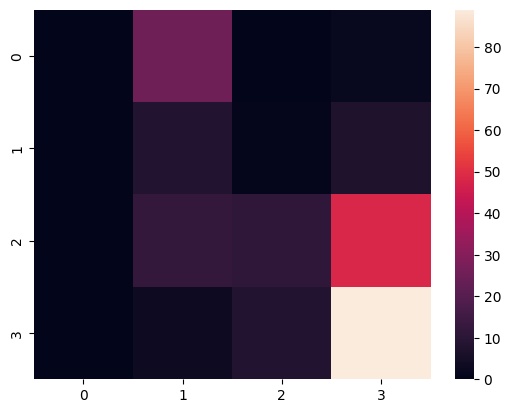

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(annotations[:,0], annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [ ]:
scotts_pi(annotations[:,0], annotations[:,1])

0.1718296489658823

In [ ]:
fleiss_kappa(annotations[::])

0.33172793089519287

In [ ]:
krippendorffs_alpha(annotations[::])

0.6830096609910166

In [ ]:
cohens_kappa(annotations[:,0], annotations[:,1])

0.21800882515168224

In [ ]:
m = pairwise_matrix(cohens_kappa, annotations)
print(m)

[[1.         0.21800883 0.49839271]
 [0.21800883 1.         0.32538377]
 [0.49839271 0.32538377 1.        ]]


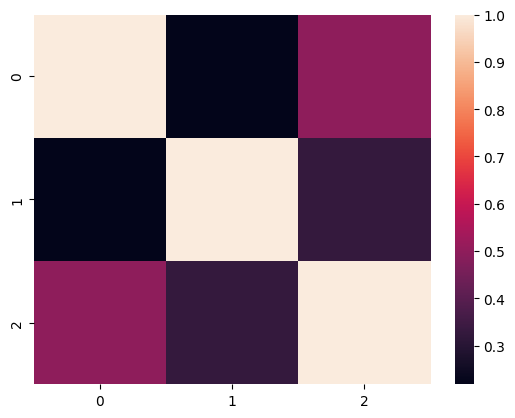

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, annotations)

0.34726177023888427

In [ ]:
cohens_weighted_kappa(annotations[:,0], annotations[:,1])

0.42380183091006995

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,annotations)

0.5235104912535613

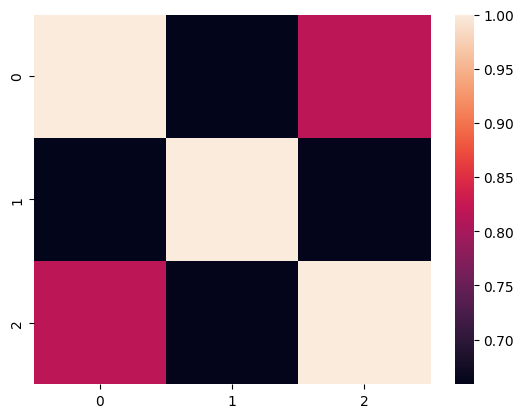

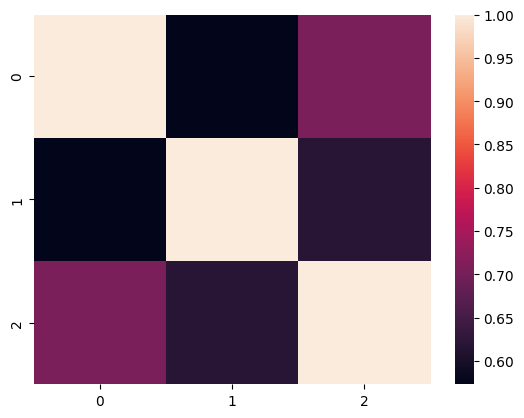

In [ ]:
n = pairwise_matrix(pearsons_rho, annotations)
m = pairwise_matrix(spearmans_rho, annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [ ]:
print(pairwise_metric_average(pearsons_rho,annotations), pairwise_metric_average(spearmans_rho,annotations))

0.7118006179897893 0.6322220654412755


In this exercise, I utilize human assessment to assess the sentiment color of newspaper articles. As is shown in the analysis, the performance of human assessment is not very satisfying but still acceptable. Besides, I also find that the relationship between different coders may influence the similarity. Coder 1 and Coder 3 are close friends, thus their assessment similarity is significantly stronger.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

,vect,category
506,"[0.6183262211872166, -1.0857750056553204]",0
194,"[-0.3406168797106817, 0.4549177199954029]",0
118,"[-0.9918334910594522, -0.10591246682958125]",0
292,"[-0.11548069638916464, -0.3899818153606279]",0
298,"[-0.5069384947266555, 0.19975700265254331]",0
...,...,...
472,"[-0.5843078559659771, 0.8168917794061781]",0
687,"[-0.5951672973052204, -0.4989404717640506]",1
358,"[0.7135494384129243, -0.6715229727198999]",0
563,"[-0.0166144944043759, 0.7473813690080264]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


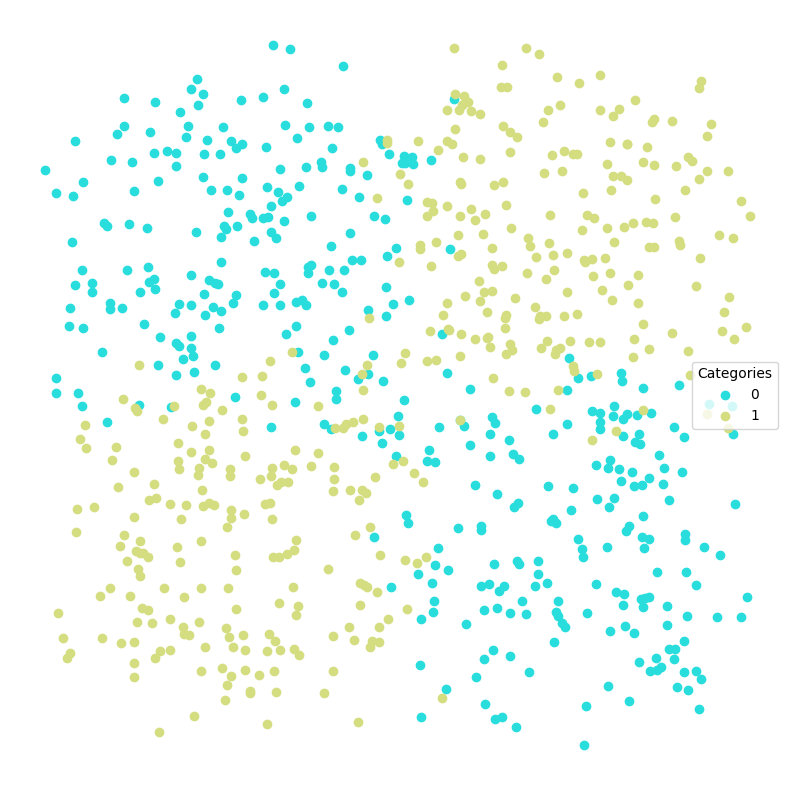

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

506      [0.6183262211872166, -1.0857750056553204]
194      [-0.3406168797106817, 0.4549177199954029]
118    [-0.9918334910594522, -0.10591246682958125]
292    [-0.11548069638916464, -0.3899818153606279]
298     [-0.5069384947266555, 0.19975700265254331]
                          ...                     
472      [-0.5843078559659771, 0.8168917794061781]
687     [-0.5951672973052204, -0.4989404717640506]
358      [0.7135494384129243, -0.6715229727198999]
563      [-0.0166144944043759, 0.7473813690080264]
897       [0.0874735301547663, 0.2267349016237368]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

array([[ 0.61832622, -1.08577501],
       [-0.34061688,  0.45491772],
       [-0.99183349, -0.10591247],
       ...,
       [ 0.71354944, -0.67152297],
       [-0.01661449,  0.74738137],
       [ 0.08747353,  0.2267349 ]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.88104,0.887931,0.859353,0.911504
1,0.115,0.88104,0.880952,0.814316,0.850575


This lets us look at which classes do better:

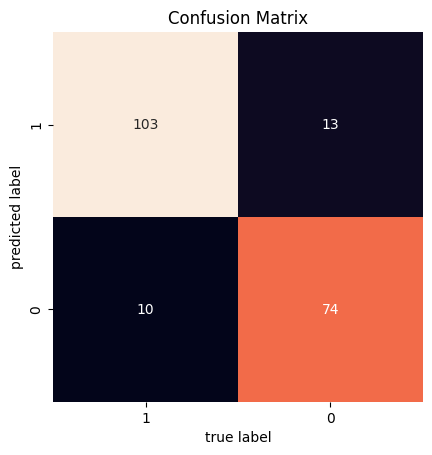

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

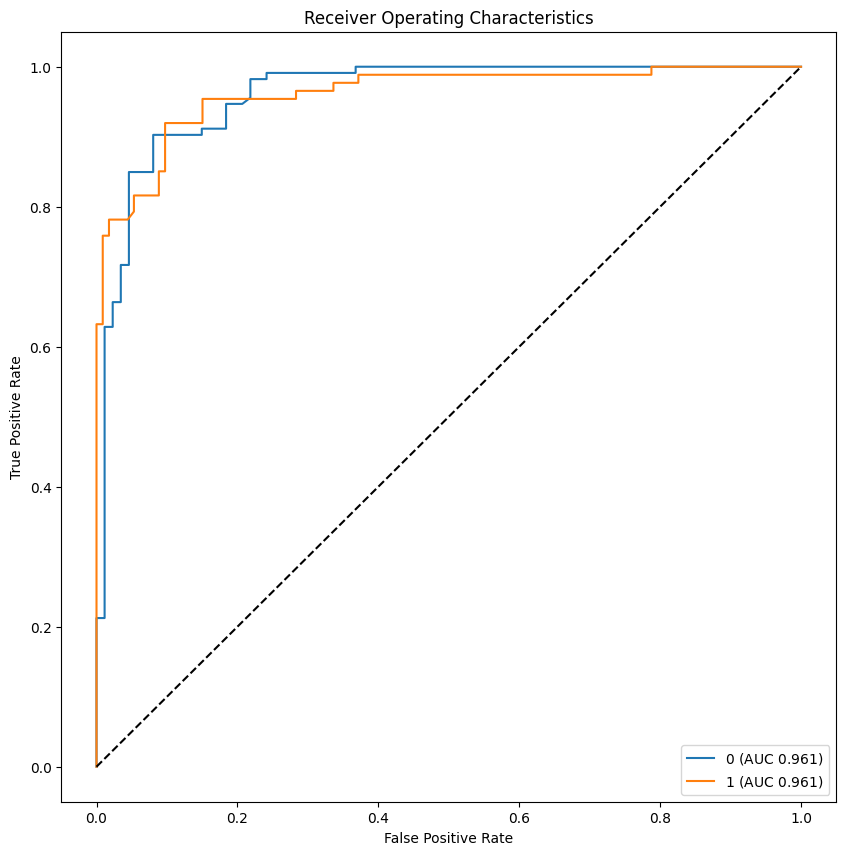

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


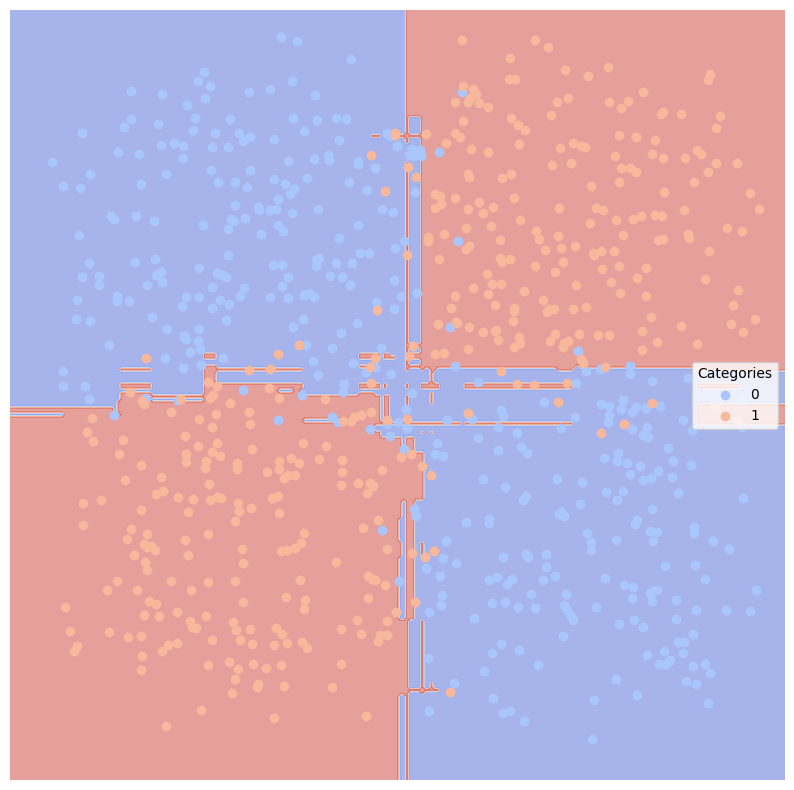

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [ ]:
!git clone https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter.git

Cloning into 'Homework-Notebooks-2024-Winter'...
remote: Enumerating objects: 4108, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4108 (delta 15), reused 40 (delta 12), pack-reused 4060
Receiving objects: 100% (4108/4108), 189.37 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Updating files: 100% (4061/4061), done.


In [36]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [37]:
dfTrain

,category,text,is_spam,binary,tokenized_text,normalized_text,vect
2130,not spam,[Spambayes] understanding high false negative ...,False,False,"[Spambayes, understanding, high, false, negati...","[spambaye, understand, high, false, negative, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
306,spam,eBay PowerSeller Secrets ...,True,True,"[eBay, PowerSeller, Secrets, 6826]","[ebay, powerseller, secret]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1313,not spam,"[zzzzteana] ""Put this in your stereo and smoke...",False,False,"[zzzzteana, Put, this, in, your, stereo, and, ...","[zzzzteana, stereo, smoke]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3213,not spam,Re: sed /s/United States/Roman Empire/g,False,False,"[Re, sed, /s, United, States, Roman, Empire, g]","[se, /s, united, states, roman, empire, g]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
338,spam,Teach and Grow Rich,True,True,"[Teach, and, Grow, Rich]","[teach, grow, rich]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
2146,not spam,[Spambayes] test sets?,False,False,"[Spambayes, test, sets]","[spambayes, test, set]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1076,not spam,Apt problems,False,False,"[Apt, problems]","[apt, problem]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1873,not spam,Re: Secure Sofware Key,False,False,"[Re, Secure, Sofware, Key]","[secure, sofware, key]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2743,not spam,Good Earnings Report,False,False,"[Good, Earnings, Report]","[good, earning, report]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [86]:
#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [87]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier()

In [88]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.083212,0.779652,0.937807,0.935446,0.967905
spam,0.083212,0.779652,0.743243,0.495027,0.591398


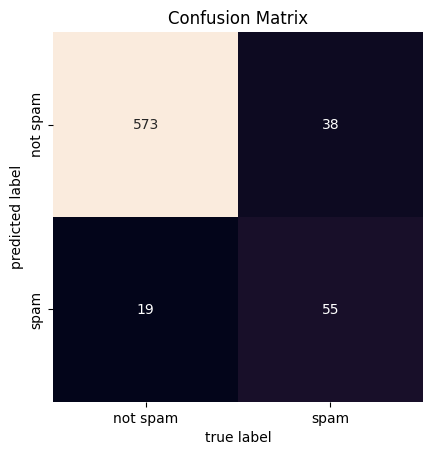

In [89]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

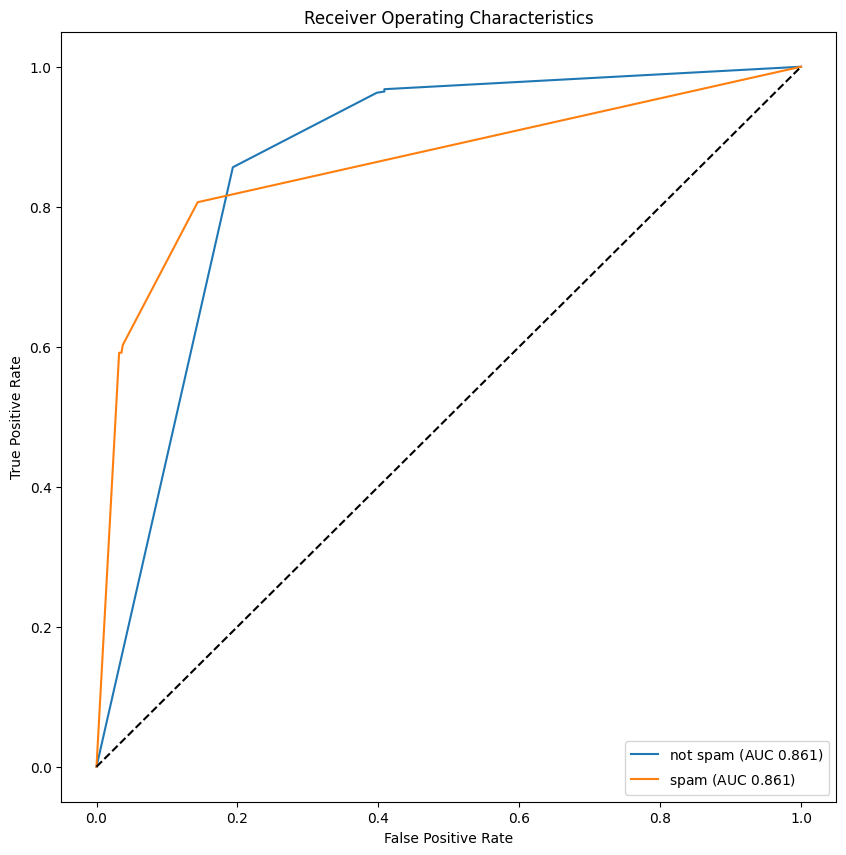

In [90]:
lucem_illud.plotMultiROC(clf, dfTest)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


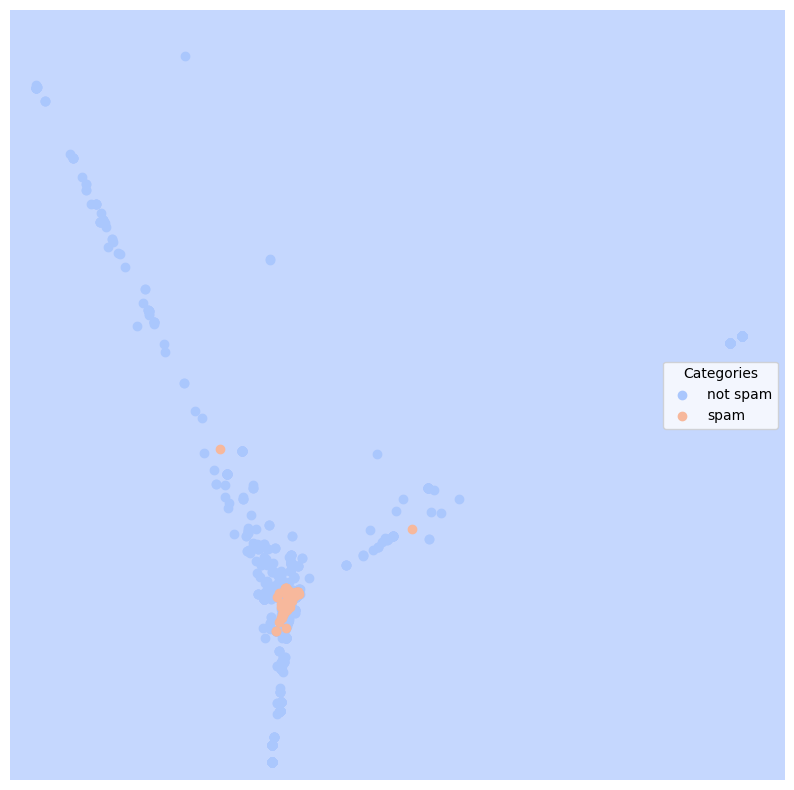

In [91]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

For the artificial datasets, the distribution of data points have a great influence on the comparison of performance between different methods. For example, in datasets that different categories are rather seperated (such as the one generated by the multiblobs), the performance of different models are similar: they all do a good job. However, categories in some other datasets (such as the one generated by the corsplit) create difference in the performance of models. In this case, some methods such as random forest classifier and gradient boost classifier performs better, while other methods such as classical logistic regression fail to complete the task.

For the empirical dataset, different methods' performance is different from dataset to dataset. For the reddit dataset, almost all methods perform perfectly except for the decision tree classifier. For the news groups dataset, the polynomial svm performs the worst. The decision tree classifier also performs bad, while the performance of other models is similar. For the senate small and big dataset, most models perform excellently except for the polynomial svm. I also observe that when there are too many categories, it's hard for PCA to reveal the differences between categories. Compared with other datasets, models' performance is not so satisfactory, among which logistic regression model performs the worst, while random forest classifier, MLP classifier and gradient boosting classifier perform relatively better.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [92]:
ObamaClintonReleases = pandas.read_csv('/content/Homework-Notebooks-2024-Winter/data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [93]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [95]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [96]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [97]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [98]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [99]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [100]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [101]:
TFVects.shape

(1367, 11170)

We can save this in the dataframe to make things easier

In [102]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [103]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [104]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

<ipython-input-105-c9d2b7441e78>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-105-c9d2b7441e78>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


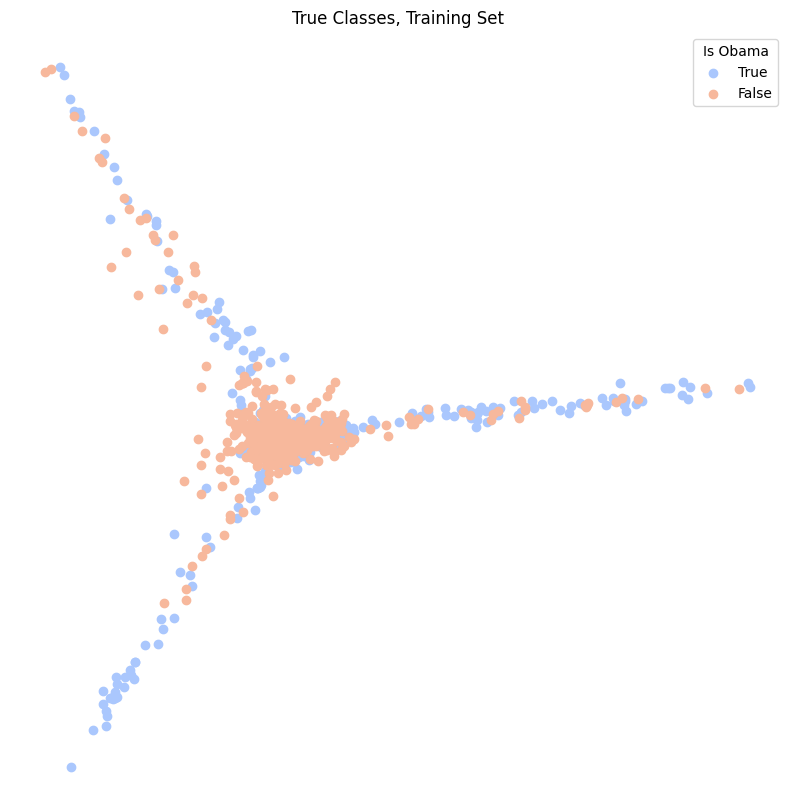

In [105]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

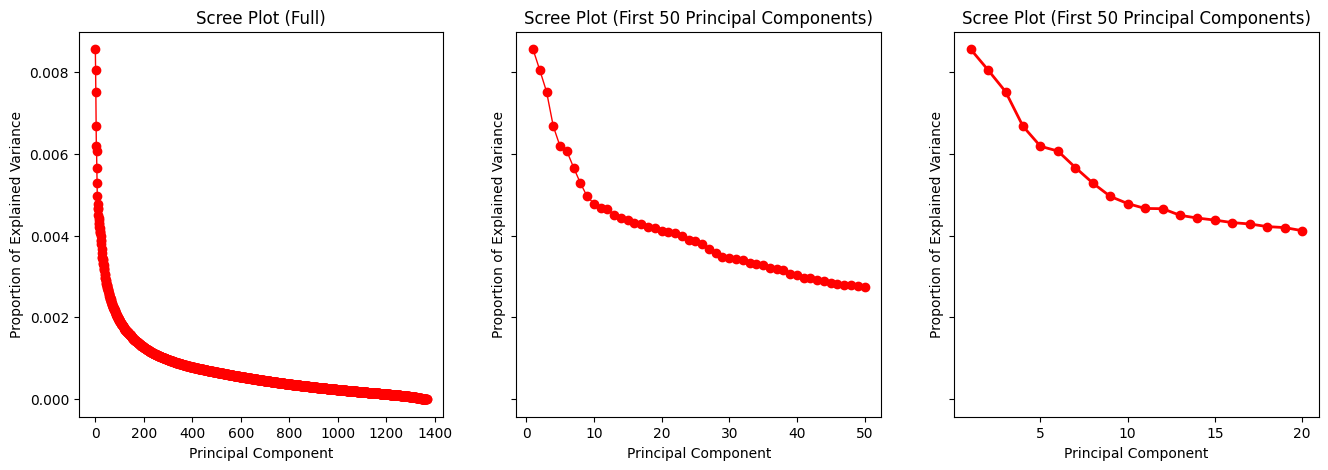

In [106]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [107]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [108]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [109]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6912948061448427

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [110]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6403508771929824

Slightly poorer. How about using more dimensions (40)?

In [111]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7322604242867593
Testing:
0.6988304093567251


Or still more (100)?

In [112]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.831016825164594
Testing:
0.7631578947368421


Or even more (200)!

In [113]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8653986832479883
Testing:
0.804093567251462


This is becoming ridiculous (400)!

In [114]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9078273591806877
Testing:
0.8011695906432749


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [115]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9575713240673006


Train the model using training data, and then test it on the testing data.

In [116]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8245614035087719


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [149]:
news_df = pandas.read_excel('/content/drive/MyDrive/eda_processed_data.xlsx')
news_df.columns

Index(['Unnamed: 0', 'natural_id', 'news_title', 'layout_num', 'layout_name',
       'date', 'article', 'url', 'length', 'tokens', 'corpus', 'title_tokens',
       'title_corpus', 'Year', 'Month', 'Day', '上海', '中国', '发展', '工作', '服务',
       '企业', '美国', '国家', '文化', '生活', 'whether_layout_1', 'a1', 'a2', 'a3'],
      dtype='object')

In [150]:
news_df.head()

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,服务,企业,美国,国家,文化,生活,whether_layout_1,a1,a2,a3
0,0,9,合作是中美双方最好的选择,2.0,要闻,2019-01-01,新华社北京1月1日电2019年1月1日，国家主席习近平与美国总统特朗普互致贺信，热烈祝贺两国...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,371.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '美国', '...",...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0
1,1,10,习近平和普京互致新年贺电,2.0,要闻,2019-01-01,新华社北京12月31日电2018年12月31日，国家主席习近平和俄罗斯总统普京互致新年贺电。...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,659.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '俄罗斯', ...",...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0
2,2,11,元旦献词,2.0,要闻,2019-01-01,上海市市长应勇2019年1月1日市民们，同志们，朋友们：值此辞别旧岁、喜迎新年之际，我代表上...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1046.0,"['上海市', '市长', '应勇', '市民', '同志', '朋友', '值此', '辞...",...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,3.0
3,3,12,人民是我们执政的最大底气,2.0,要闻,2019-01-01,新华社北京12月31日电新年前夕，国家主席习近平通过中央广播电视总台和互联网，发表了二○一九...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1931.0,"['新华社', '北京', '日电', '新年', '前夕', '国家', '主席', '习...",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,3.0
4,4,13,对标浦东奋力向前,3.0,我和我的祖国长三角新奋进特别报道,2019-01-01,漫步江北新区，记者在许多工地围栏上看到了“最近的未来”的字样。今年以来，江北新区确立了对标找...,https://paper.xinmin.cn/html/xmwb/2019-01-01/3...,417.0,"['漫步', '江北', '新区', '记者', '工地', '围栏', '看到', '最近...",...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0


In [151]:
news_df.drop(index=724,inplace=True)

In [152]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, norm='l2')
TFVects = TFVectorizer.fit_transform(news_df['corpus'])
news_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
news_df

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,企业,美国,国家,文化,生活,whether_layout_1,a1,a2,a3,vect
0,0,9,合作是中美双方最好的选择,2.0,要闻,2019-01-01,新华社北京1月1日电2019年1月1日，国家主席习近平与美国总统特朗普互致贺信，热烈祝贺两国...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,371.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '美国', '...",...,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,10,习近平和普京互致新年贺电,2.0,要闻,2019-01-01,新华社北京12月31日电2018年12月31日，国家主席习近平和俄罗斯总统普京互致新年贺电。...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,659.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '俄罗斯', ...",...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,11,元旦献词,2.0,要闻,2019-01-01,上海市市长应勇2019年1月1日市民们，同志们，朋友们：值此辞别旧岁、喜迎新年之际，我代表上...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1046.0,"['上海市', '市长', '应勇', '市民', '同志', '朋友', '值此', '辞...",...,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,12,人民是我们执政的最大底气,2.0,要闻,2019-01-01,新华社北京12月31日电新年前夕，国家主席习近平通过中央广播电视总台和互联网，发表了二○一九...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1931.0,"['新华社', '北京', '日电', '新年', '前夕', '国家', '主席', '习...",...,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,13,对标浦东奋力向前,3.0,我和我的祖国长三角新奋进特别报道,2019-01-01,漫步江北新区，记者在许多工地围栏上看到了“最近的未来”的字样。今年以来，江北新区确立了对标找...,https://paper.xinmin.cn/html/xmwb/2019-01-01/3...,417.0,"['漫步', '江北', '新区', '记者', '工地', '围栏', '看到', '最近...",...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,719,835,“跨界”巧搭传统 革新“戏曲美学”,14.0,文体新闻,2019-01-10,中国传统戏曲演绎莎士比亚名作会擦出怎样的火花？听惯了的锣鼓经若换成爵士鼓会否串味？打击乐若融...,https://paper.xinmin.cn/html/xmwb/2019-01-10/1...,752.0,"['中国', '传统', '戏曲', '演绎', '莎士比亚', '名作', '火花', '...",...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
720,720,836,《微光》属于上海更属于全世界,14.0,文体新闻,2019-01-10,乐声、掌声、欢呼声……日前，在2019美国全国演艺出品人年会（APAP）推介剧目现场，中国上...,https://paper.xinmin.cn/html/xmwb/2019-01-10/1...,1028.0,"['乐声', '掌声', '欢呼声', '日前', '美国', '全国', '演艺', '出...",...,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
721,721,837,英雄第一名,15.0,文体新闻/文娱,2019-01-10,可喜可贺！荧屏上，中国真正的英雄故事，拿下了第一名。“良心综艺！跟各种明星八卦相比，这些真正...,https://paper.xinmin.cn/html/xmwb/2019-01-10/1...,477.0,"['可喜可贺', '荧屏', '中国', '真正', '英雄', '故事', '拿下', '...",...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
722,722,838,图书馆搬到家门口不出门照样看演出,15.0,文体新闻/文娱,2019-01-10,本报讯（记者吴旭颖）对徐汇区的居民们来说，2019年将是文化生活更加美好的一年：他们不用走出...,https://paper.xinmin.cn/html/xmwb/2019-01-10/1...,571.0,"['本报讯', '记者', '吴旭颖', '徐汇区', '居民', '文化', '生活', ...",...,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [153]:
train_data_df, test_data_df = sklearn.model_selection.train_test_split(news_df, test_size=0.2)

In [154]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [155]:
train_data_df['pca'] = [r for r in reduced_data]

<ipython-input-146-a4f9fc1603b4>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = 0)
<ipython-input-146-a4f9fc1603b4>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = 1)


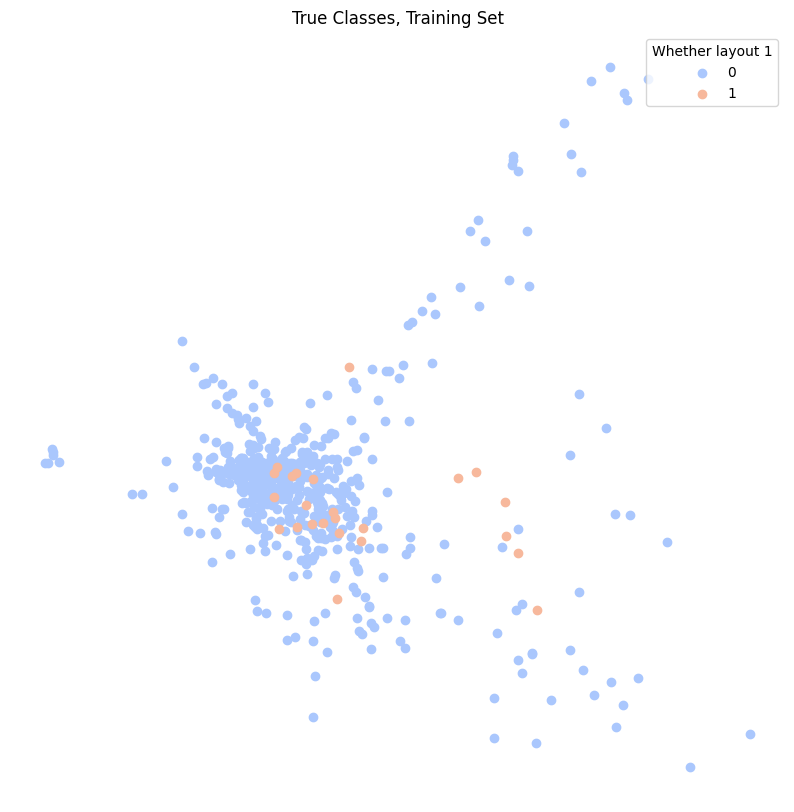

In [146]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

a = np.stack(train_data_df[train_data_df['whether_layout_1'] == 0]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = 0)

a = np.stack(train_data_df[train_data_df['whether_layout_1'] == 1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = 1)

ax.legend(loc = 'upper right', title = 'Whether layout 1')
plt.title('True Classes, Training Set')
plt.show()

In [156]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['whether_layout_1'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['whether_layout_1']))

0.9689119170984456


In [157]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['whether_layout_1']))

0.9448275862068966


In [ ]:
test_data_df.rename(columns={'whether_layout_1': 'category'}, inplace=True)
test_data_df

In [165]:
train_data_df.rename(columns={'whether_layout_1': 'category'}, inplace=True)
train_data_df

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,美国,国家,文化,生活,category,a1,a2,a3,vect,pca
11,11,25,盐城跨区域引水工程收官,11.0,中国新闻/长三角,2019-01-01,本报讯（记者唐闻宜）盐城跨区域引水工程收官暨射阳支线通水仪式近日举行，此举标志着盐城最大的饮...,https://paper.xinmin.cn/html/xmwb/2019-01-01/1...,400.0,"['本报讯', '记者', '唐闻宜', '盐城', '区域', '引水', '工程', '...",...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020094513439108248, 0.08128554006972932, -0..."
273,273,321,退役军人专场招聘会下周六举行,6.0,综合新闻,2019-01-05,本报讯（记者江跃中）上海市退役军人事务局正式成立后筹划的首个全市退役军人专场招聘会将于1月1...,https://paper.xinmin.cn/html/xmwb/2019-01-05/6...,210.0,"['本报讯', '记者', '江跃中', '上海市', '退役军人', '事务局', '正式...",...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001830329285415019, 0.038168428157389724, 0..."
30,30,45,期待,16.0,文体新闻/体育,2019-01-01,跨过2018，新的一年来到了。2019年的首个国际性大赛，当属1月5日即将开幕的阿联酋亚洲杯...,https://paper.xinmin.cn/html/xmwb/2019-01-01/1...,350.0,"['跨过', '一年', '来到', '首个', '国际性', '大赛', '当属', '即...",...,0.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.013739052946624733, -0.11876565507762753, ..."
523,523,606,今年回购规模有望再创新高,9.0,综合新闻/广告,2019-01-08,上周3个交易日有11家公司发布回购预案，回购金额按上限计算近87亿元，平均回购额远超去年。2...,https://paper.xinmin.cn/html/xmwb/2019-01-08/9...,943.0,"['上周', '交易日', '有家', '公司', '发布', '回购', '预案', '回...",...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009827714663476919, 0.030955703725206497, 0..."
240,240,282,为快乐列表,21.0,夜光杯,2019-01-04,（美国）C.W.梅特卡夫孙宝成（编译）在从事临终关怀工作时，我从一个年轻人身上学到了一种有效...,https://paper.xinmin.cn/html/xmwb/2019-01-04/2...,441.0,"['美国', '梅特卡夫', '孙宝成', '编译', '从事', '临终关怀', '工作'...",...,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020248640272700066, -0.08890750371128461, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,34,49,笑脸,17.0,文体新闻/体育,2019-01-01,有人说，欢笑的人最美丽。2019年的第一天，在上海各个地标点上，处处有这样最美的人。长宁区黄...,https://paper.xinmin.cn/html/xmwb/2019-01-01/1...,352.0,"['有人', '欢笑', '美丽', '第一天', '上海', '标点', '处处', '最...",...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.06745917873160635, -0.052947874391881956, ..."
349,349,410,蓬佩奥访中东8国要安抚地区盟友,5.0,国际新闻,2019-01-06,据新华社华盛顿1月4日电美国国务院4日表示，国务卿蓬佩奥将于本月8日起访问中东8国，将向地区...,https://paper.xinmin.cn/html/xmwb/2019-01-06/5...,350.0,"['新华社', '华盛顿', '日电', '美国国务院', '表示', '国务卿', '蓬佩...",...,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2570241948007442, -0.0473818022101207, -0.0..."
221,221,262,英国所有中小学生明年起需培训急救,15.0,国际新闻,2019-01-04,新华社上午电为提高突发心脏病患者的生存几率，英国教育大臣达米安·海因兹宣布，所有英国学生20...,https://paper.xinmin.cn/html/xmwb/2019-01-04/1...,302.0,"['新华社', '上午', '电为', '提高', '突发', '心脏病', '患者', '...",...,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011751825684994872, -0.028074585097515155, ..."
278,278,326,央行开年降准1个百分点,6.0,综合新闻,2019-01-05,本报讯（首席记者谈璎）2019年第一周，降准拍马赶到。中国人民银行昨晚宣布决定下调金融机构存...,https://paper.xinmin.cn/html/xmwb/2019-01-05/6...,1066.0,"['本报讯', '首席记者', '谈璎年', '第一周', '降准', '拍马', '赶到'...",...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05043581021147039, 0.14790652707261134, 0.0..."


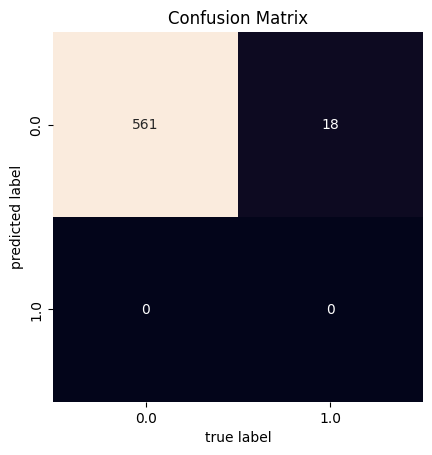

In [166]:
lucem_illud.plotConfusionMatrix(logistic_l1, train_data_df)

It seems that although the score of the model performance is high, the actual performance is not satisfying, as the model simply classify all the articles as not in the first layout.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


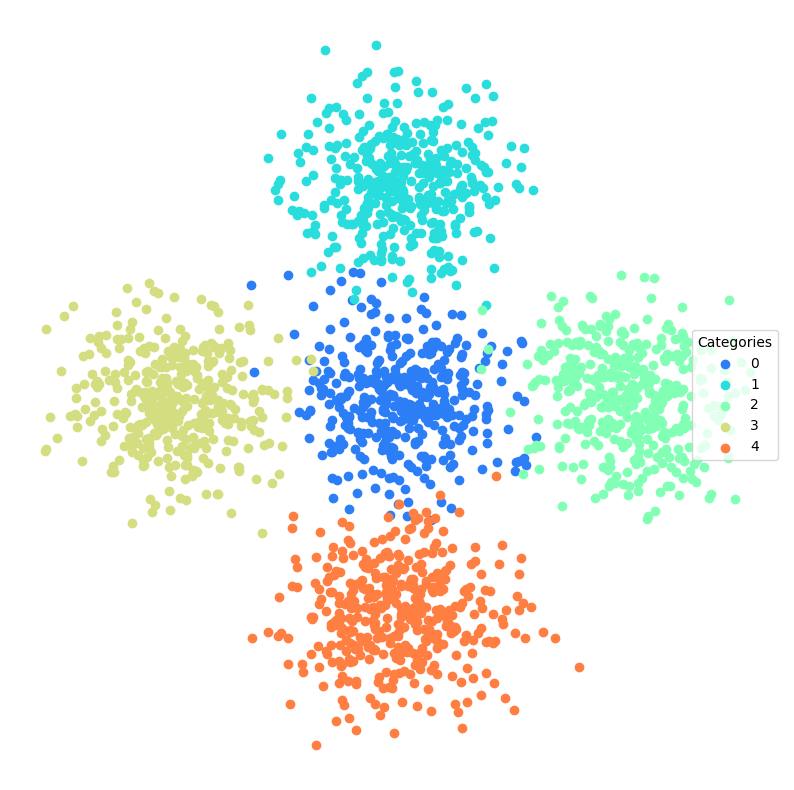

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


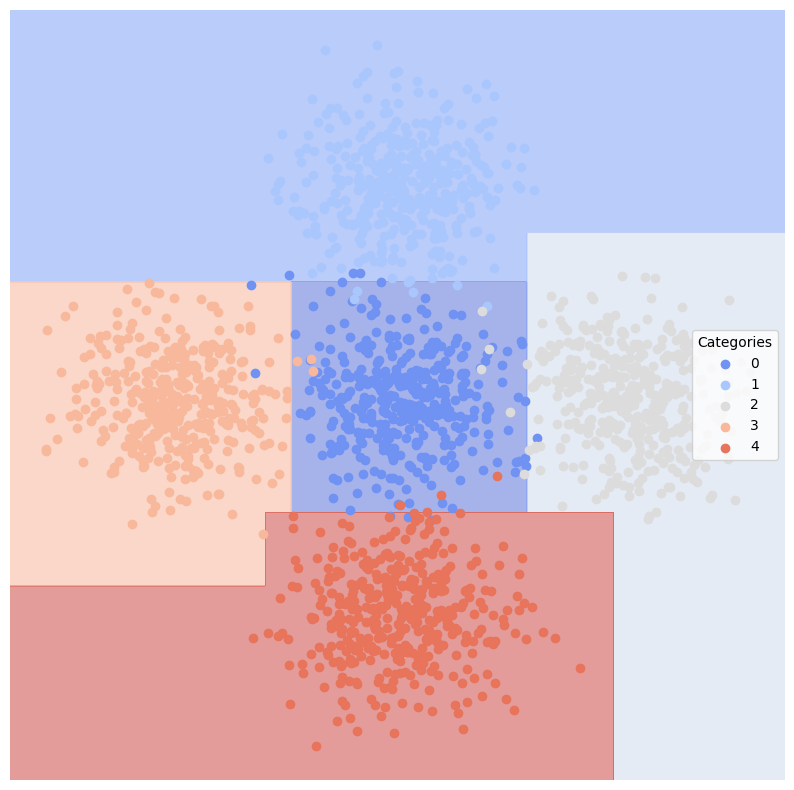

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.012,0.977692,0.979798,0.948994,0.960396
1,0.006,0.988750,0.989899,0.974101,0.980000
2,0.002,0.998756,0.989899,0.989899,1.000000
3,0.008,0.991404,0.971698,0.964355,0.990385
4,0.004,0.993605,0.989691,0.981488,0.989691


Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.984

What happens if we trim the tree?

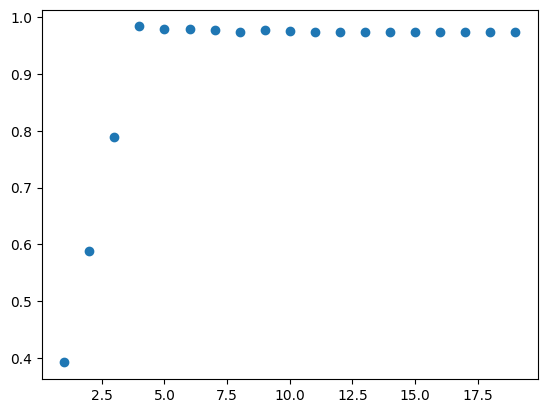

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


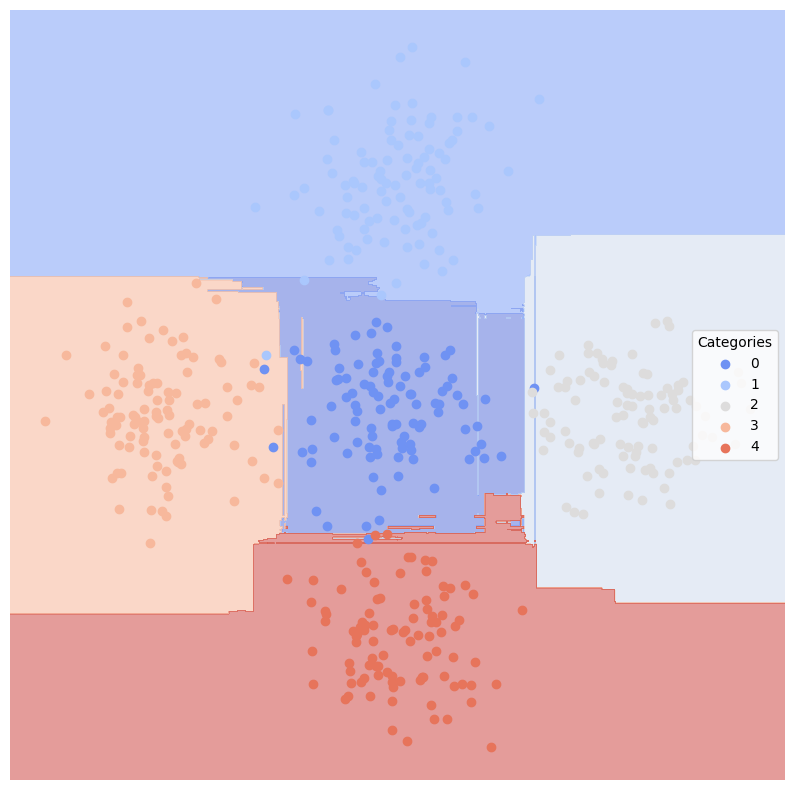

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.012,0.977692,0.979798,0.948994,0.960396
1,0.004,0.990000,1.000000,0.984000,0.980000
2,0.004,0.997512,0.980000,0.980000,1.000000
3,0.006,0.996212,0.971963,0.971963,1.000000
4,0.002,0.994845,1.000000,0.991691,0.989691


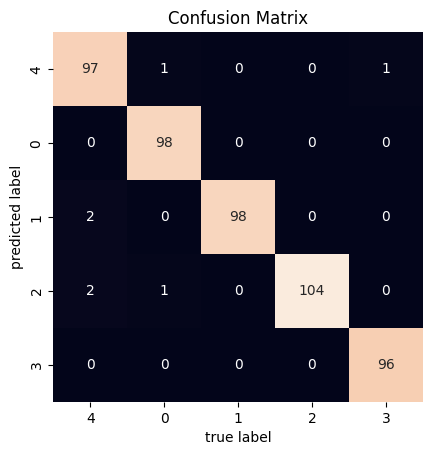

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [7]:
news_df = pandas.read_excel('/content/drive/MyDrive/eda_processed_data.xlsx')
news_df.rename(columns={'a1': 'category'}, inplace=True)
news_df = news_df.loc[:213]
news_df

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,服务,企业,美国,国家,文化,生活,whether_layout_1,category,a2,a3
0,0,9,合作是中美双方最好的选择,2.0,要闻,2019-01-01,新华社北京1月1日电2019年1月1日，国家主席习近平与美国总统特朗普互致贺信，热烈祝贺两国...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,371.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '美国', '...",...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0
1,1,10,习近平和普京互致新年贺电,2.0,要闻,2019-01-01,新华社北京12月31日电2018年12月31日，国家主席习近平和俄罗斯总统普京互致新年贺电。...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,659.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '俄罗斯', ...",...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0
2,2,11,元旦献词,2.0,要闻,2019-01-01,上海市市长应勇2019年1月1日市民们，同志们，朋友们：值此辞别旧岁、喜迎新年之际，我代表上...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1046.0,"['上海市', '市长', '应勇', '市民', '同志', '朋友', '值此', '辞...",...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,3.0
3,3,12,人民是我们执政的最大底气,2.0,要闻,2019-01-01,新华社北京12月31日电新年前夕，国家主席习近平通过中央广播电视总台和互联网，发表了二○一九...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1931.0,"['新华社', '北京', '日电', '新年', '前夕', '国家', '主席', '习...",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,3.0
4,4,13,对标浦东奋力向前,3.0,我和我的祖国长三角新奋进特别报道,2019-01-01,漫步江北新区，记者在许多工地围栏上看到了“最近的未来”的字样。今年以来，江北新区确立了对标找...,https://paper.xinmin.cn/html/xmwb/2019-01-01/3...,417.0,"['漫步', '江北', '新区', '记者', '工地', '围栏', '看到', '最近...",...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,209,248,跨年夜差点“露宿街头”,9.0,社会新闻,2019-01-04,提前数月在民宿平台Airbnb（中文名“爱彼迎”）上预订房间，入住当天，房间里却另有一批房客...,https://paper.xinmin.cn/html/xmwb/2019-01-04/9...,801.0,"['提前', '数月', '民宿', '平台', '中文名', '爱彼迎', '预订', '...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
210,210,249,“研发”流水线 销售假“戴森”,9.0,社会新闻,2019-01-04,电吹风是生活中常用的工具，便宜的几十块，好点的几百块，高端的上千块，戴森的三千块……“小姐姐...,https://paper.xinmin.cn/html/xmwb/2019-01-04/9...,1180.0,"['电吹风', '生活', '常用', '工具', '便宜', '几十块', '好点', '...",...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
211,211,250,华为云：进入智能计算“芯”时代 诠释算力升级新内涵,10.0,中国新闻/广告,2019-01-04,华为智能化战略简单来看就是三点：联接+计算+云，三者互为基础，互相促进。近日，华为智能计算战...,https://paper.xinmin.cn/html/xmwb/2019-01-04/1...,2161.0,"['华为', '智能化', '战略', '简单', '来看', '三点', '联接', '计...",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0
212,212,251,为祖国奋飞，为新时代护航,10.0,中国新闻/广告,2019-01-04,郝井文，空军航空兵某旅旅长，空军特级飞行员，“全军爱军精武标兵”。他是空军首届对抗空战比武“...,https://paper.xinmin.cn/html/xmwb/2019-01-04/1...,1892.0,"['郝井文', '空军航空兵', '某旅', '旅长', '空军', '特级', '飞行员'...",...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0


In [8]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, norm='l2')
TFVects = TFVectorizer.fit_transform(news_df['corpus'])
news_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
news_df

,Unnamed: 0,natural_id,news_title,layout_num,layout_name,date,article,url,length,tokens,...,企业,美国,国家,文化,生活,whether_layout_1,category,a2,a3,vect
0,0,9,合作是中美双方最好的选择,2.0,要闻,2019-01-01,新华社北京1月1日电2019年1月1日，国家主席习近平与美国总统特朗普互致贺信，热烈祝贺两国...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,371.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '美国', '...",...,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,10,习近平和普京互致新年贺电,2.0,要闻,2019-01-01,新华社北京12月31日电2018年12月31日，国家主席习近平和俄罗斯总统普京互致新年贺电。...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,659.0,"['新华社', '北京', '日电', '国家', '主席', '习近平', '俄罗斯', ...",...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,11,元旦献词,2.0,要闻,2019-01-01,上海市市长应勇2019年1月1日市民们，同志们，朋友们：值此辞别旧岁、喜迎新年之际，我代表上...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1046.0,"['上海市', '市长', '应勇', '市民', '同志', '朋友', '值此', '辞...",...,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,12,人民是我们执政的最大底气,2.0,要闻,2019-01-01,新华社北京12月31日电新年前夕，国家主席习近平通过中央广播电视总台和互联网，发表了二○一九...,https://paper.xinmin.cn/html/xmwb/2019-01-01/2...,1931.0,"['新华社', '北京', '日电', '新年', '前夕', '国家', '主席', '习...",...,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,13,对标浦东奋力向前,3.0,我和我的祖国长三角新奋进特别报道,2019-01-01,漫步江北新区，记者在许多工地围栏上看到了“最近的未来”的字样。今年以来，江北新区确立了对标找...,https://paper.xinmin.cn/html/xmwb/2019-01-01/3...,417.0,"['漫步', '江北', '新区', '记者', '工地', '围栏', '看到', '最近...",...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,209,248,跨年夜差点“露宿街头”,9.0,社会新闻,2019-01-04,提前数月在民宿平台Airbnb（中文名“爱彼迎”）上预订房间，入住当天，房间里却另有一批房客...,https://paper.xinmin.cn/html/xmwb/2019-01-04/9...,801.0,"['提前', '数月', '民宿', '平台', '中文名', '爱彼迎', '预订', '...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
210,210,249,“研发”流水线 销售假“戴森”,9.0,社会新闻,2019-01-04,电吹风是生活中常用的工具，便宜的几十块，好点的几百块，高端的上千块，戴森的三千块……“小姐姐...,https://paper.xinmin.cn/html/xmwb/2019-01-04/9...,1180.0,"['电吹风', '生活', '常用', '工具', '便宜', '几十块', '好点', '...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
211,211,250,华为云：进入智能计算“芯”时代 诠释算力升级新内涵,10.0,中国新闻/广告,2019-01-04,华为智能化战略简单来看就是三点：联接+计算+云，三者互为基础，互相促进。近日，华为智能计算战...,https://paper.xinmin.cn/html/xmwb/2019-01-04/1...,2161.0,"['华为', '智能化', '战略', '简单', '来看', '三点', '联接', '计...",...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014..."
212,212,251,为祖国奋飞，为新时代护航,10.0,中国新闻/广告,2019-01-04,郝井文，空军航空兵某旅旅长，空军特级飞行员，“全军爱军精武标兵”。他是空军首届对抗空战比武“...,https://paper.xinmin.cn/html/xmwb/2019-01-04/1...,1892.0,"['郝井文', '空军航空兵', '某旅', '旅长', '空军', '特级', '飞行员'...",...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
train_data_df, test_data_df = sklearn.model_selection.train_test_split(news_df, test_size=0.2)

In [16]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [17]:
train_data_df['pca'] = [r for r in reduced_data]

<ipython-input-19-41673700c262>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = 0)
<ipython-input-19-41673700c262>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = 1)
<ipython-input-19-41673700c262>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will 

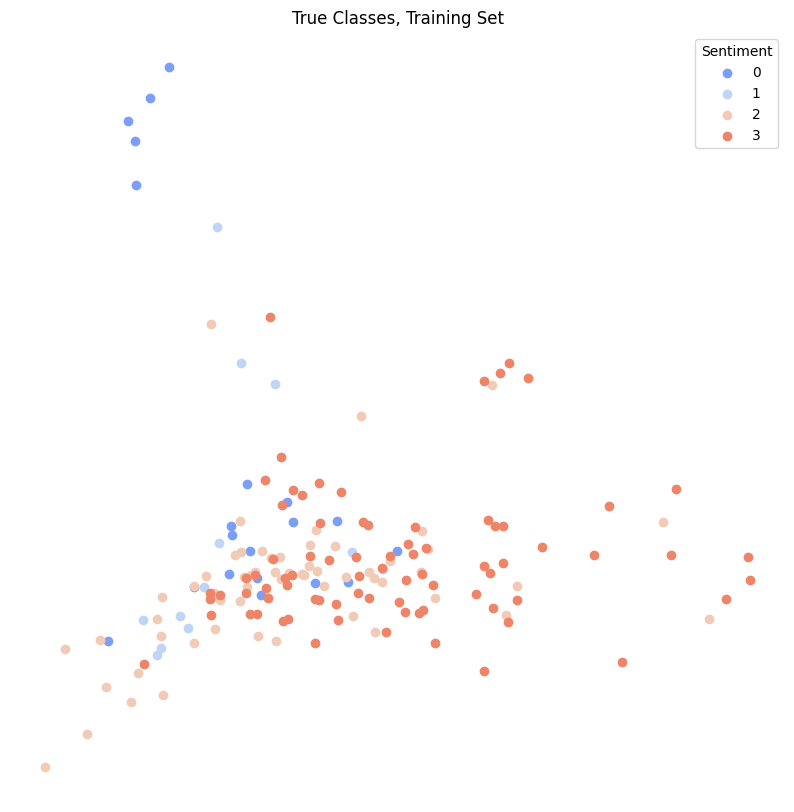

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 4)

a = np.stack(train_data_df[train_data_df['category'] == 0]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = 0)

a = np.stack(train_data_df[train_data_df['category'] == 1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = 1)

a = np.stack(train_data_df[train_data_df['category'] == 2]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[2], label = 2)

a = np.stack(train_data_df[train_data_df['category'] == 3]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[3], label = 3)

ax.legend(loc = 'upper right', title = 'Sentiment')
plt.title('True Classes, Training Set')
plt.show()

In [29]:
clf_tree = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(random_state=0)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


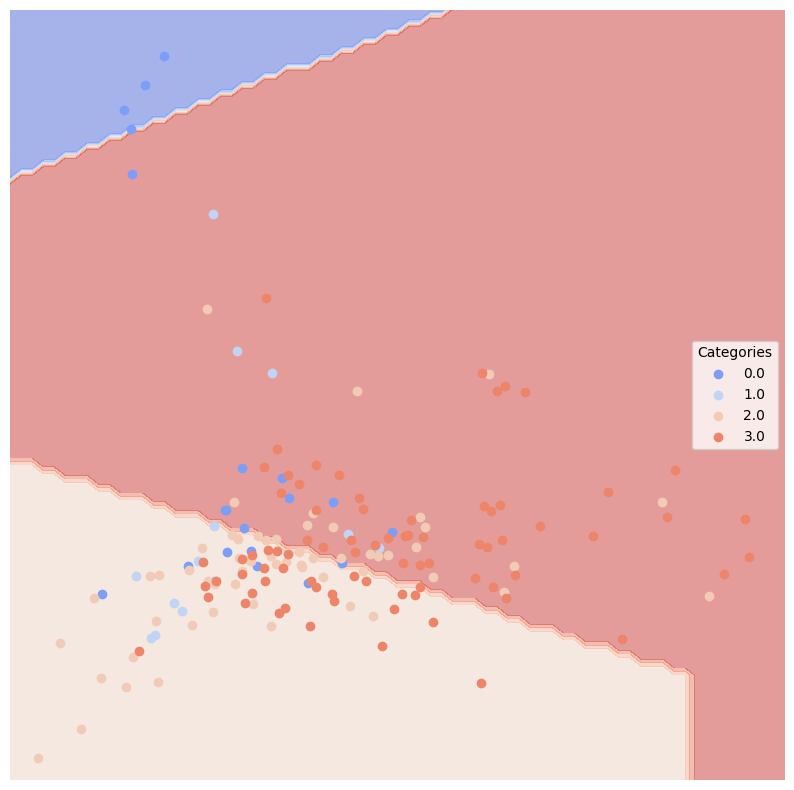

In [30]:
lucem_illud.plotregions(clf_tree, train_data_df)

In [31]:
lucem_illud.evaluateClassifier(clf_tree, news_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0.0,0.028037,0.888889,1.000000,0.805815,0.777778
1.0,0.037383,0.922348,0.700000,0.621846,0.875000
2.0,0.098131,0.908845,0.804878,0.771561,0.929577
3.0,0.088785,0.908070,0.945055,0.878168,0.860000


In [32]:
sklearn.metrics.accuracy_score(news_df['category'],clf_tree.predict(np.stack(news_df['vect'], axis = 0)))

0.8738317757009346

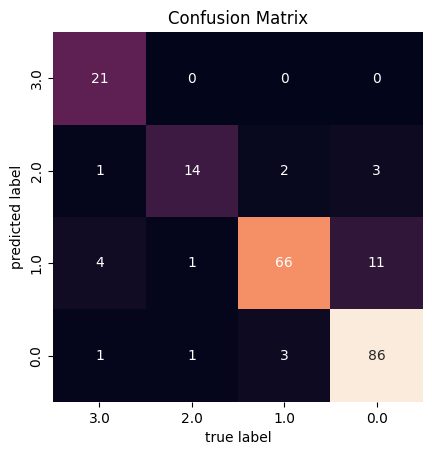

In [33]:
lucem_illud.plotConfusionMatrix(clf_tree, news_df)

Random Forest Classifier

In [24]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

In [25]:
bag.fit(np.stack(news_df['vect'], axis =0), news_df['category'])

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

In [34]:
sklearn.metrics.accuracy_score(news_df['category'],bag.predict(np.stack(news_df['vect'], axis = 0)))

0.9813084112149533

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


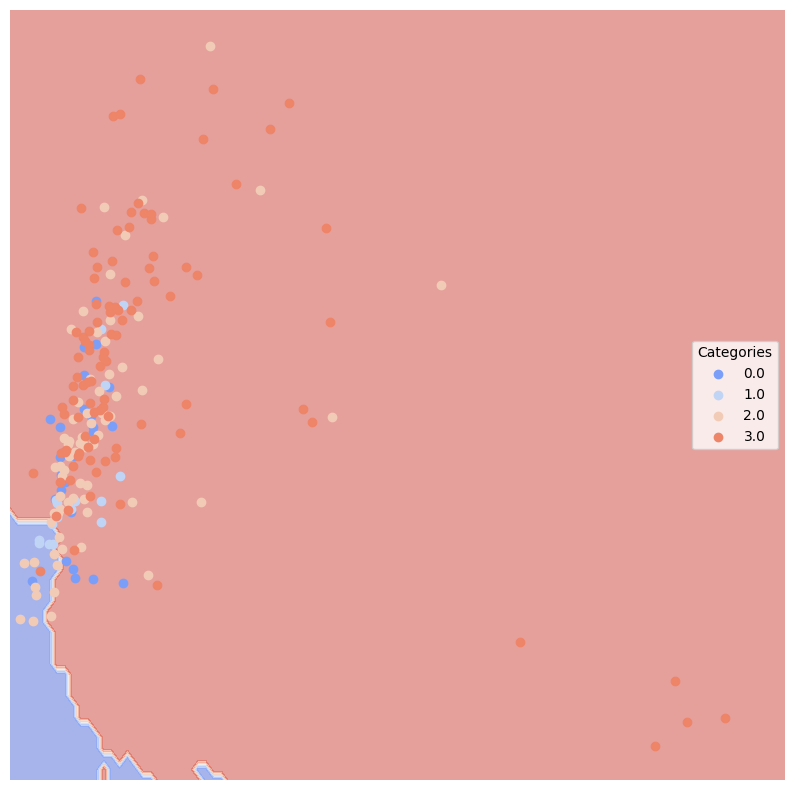

In [26]:
lucem_illud.plotregions(bag, news_df)

In [27]:
lucem_illud.evaluateClassifier(bag, news_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0.0,0.004673,0.981481,1.000000,0.967636,0.962963
1.0,0.014019,0.906250,1.000000,0.826519,0.812500
2.0,0.018692,0.986014,0.946667,0.946667,1.000000
3.0,0.000000,1.000000,1.000000,1.000000,1.000000


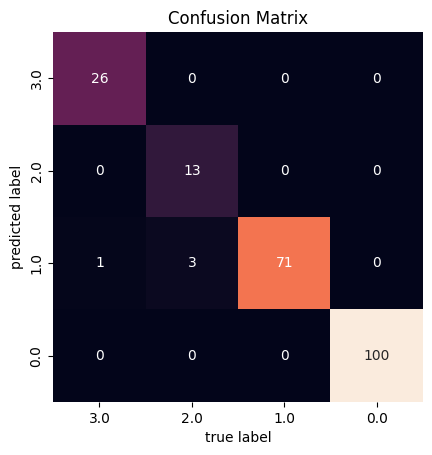

In [28]:
lucem_illud.plotConfusionMatrix(bag, news_df)

Apparantly, the random forest classifier does a much better job compared with the simple decision tree classifier.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [36]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.182346,0.5,0.000000,0.182346,0.0
sci.space,0.283391,0.5,0.000000,0.283391,0.0
soc.religion.christian,0.274100,0.5,0.000000,0.274100,0.0
comp.graphics,0.739837,0.5,0.260163,0.260163,1.0


And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.31554524361948955


Let's produce another confusion matrix:

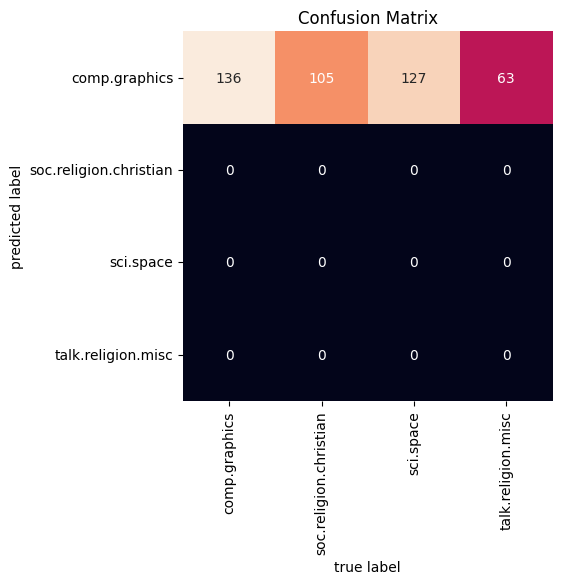

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [37]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [40]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [41]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0.0,0.116279,0.642857,1.000000,0.401993,0.285714
1.0,0.069767,0.500000,0.000000,0.069767,0.000000
2.0,0.372093,0.486559,0.250000,0.274225,0.166667
3.0,0.418605,0.587662,0.545455,0.537300,0.857143


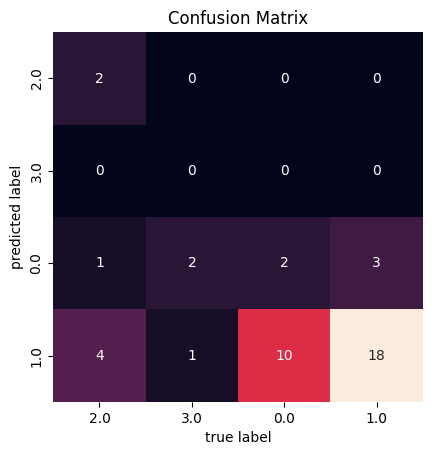

In [42]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

The performance of the model is not very satisfying

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('/content/Homework-Notebooks-2024-Winter/data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009375,0.982558,1.000000,0.974491,0.965116
Bad Roommates: Tales of Irritation,0.012500,0.983047,0.974359,0.955625,0.974359
Tales From Tech Support,0.012500,0.987391,0.962500,0.953285,0.987179
Relationships,0.021875,0.972505,0.949367,0.922228,0.961538


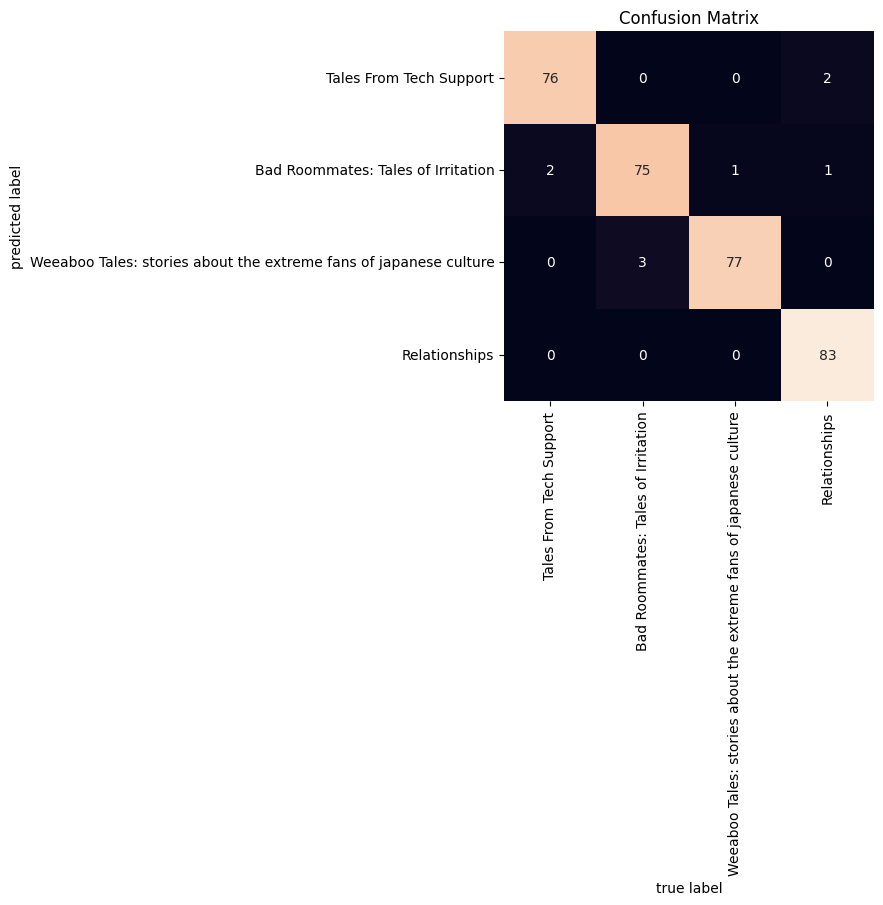

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


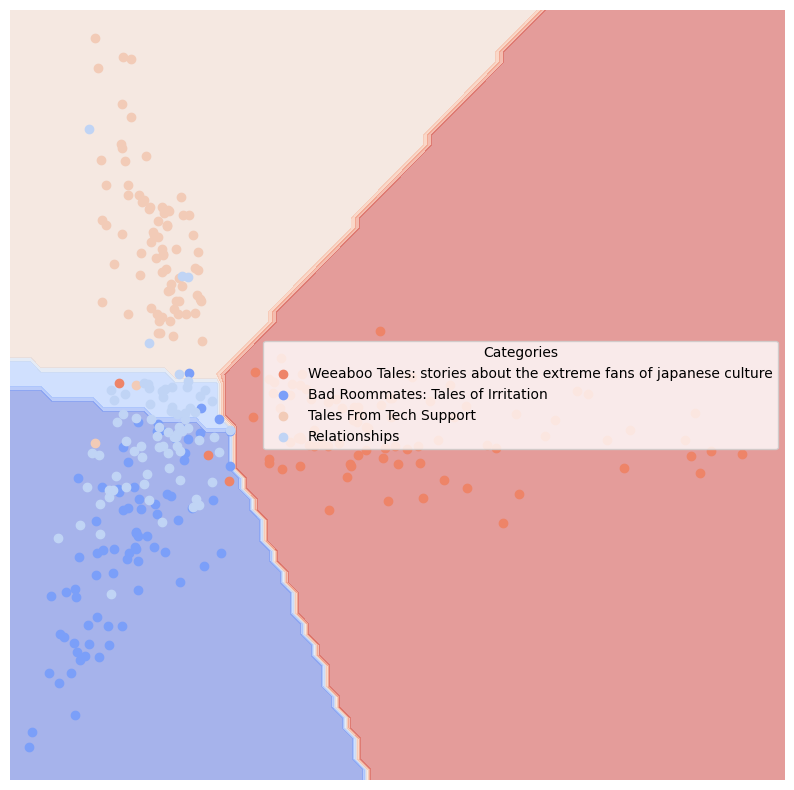

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012500,0.984099,0.976744,0.960279,0.976744
Bad Roommates: Tales of Irritation,0.021875,0.963816,0.973333,0.926565,0.935897
Tales From Tech Support,0.006250,0.995868,0.975000,0.975000,1.000000
Relationships,0.021875,0.972505,0.949367,0.922228,0.961538


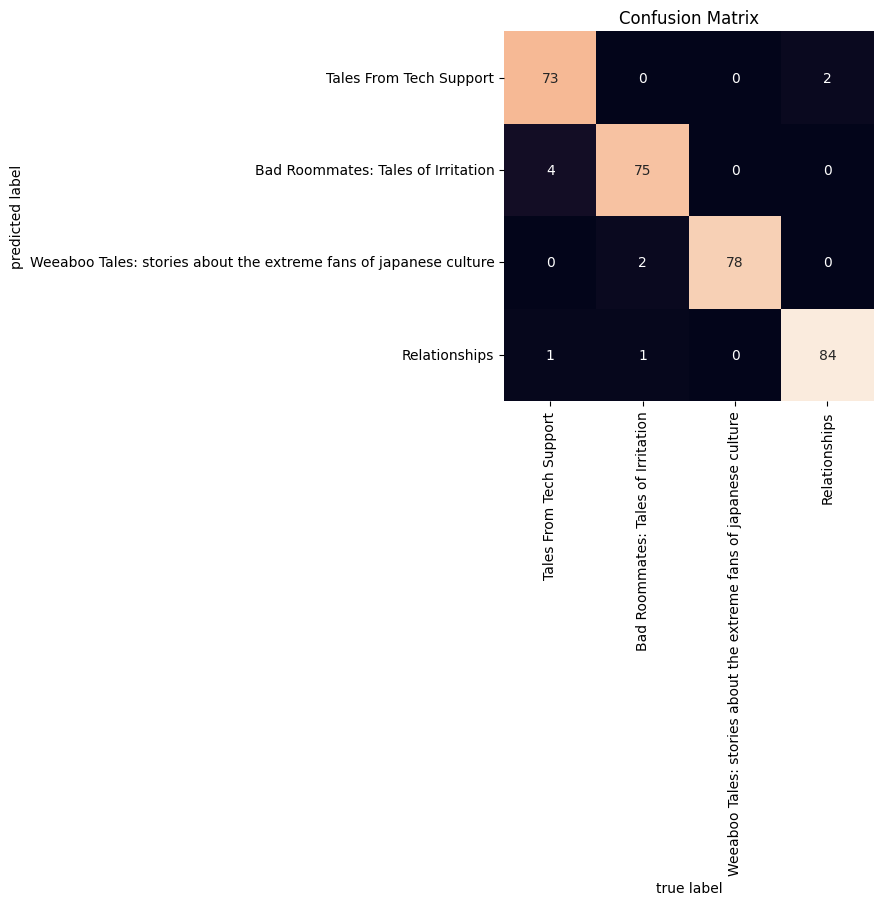

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


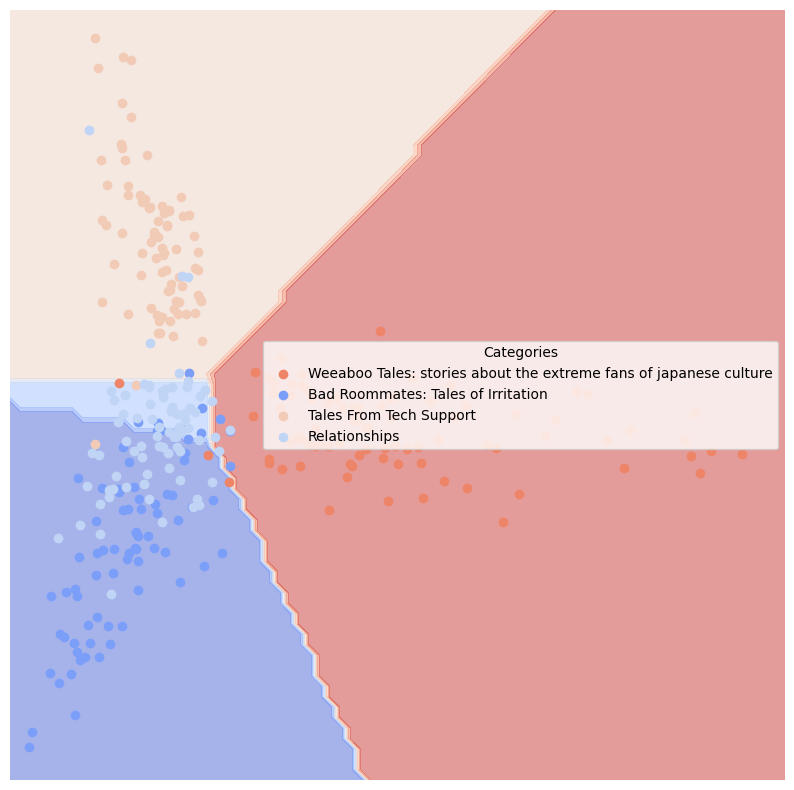

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [43]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier()

In [44]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0.0,0.139535,0.628968,0.666667,0.306755,0.285714
1.0,0.069767,0.500000,0.000000,0.069767,0.000000
2.0,0.325581,0.518817,0.333333,0.288114,0.166667
3.0,0.441860,0.564935,0.529412,0.523549,0.857143


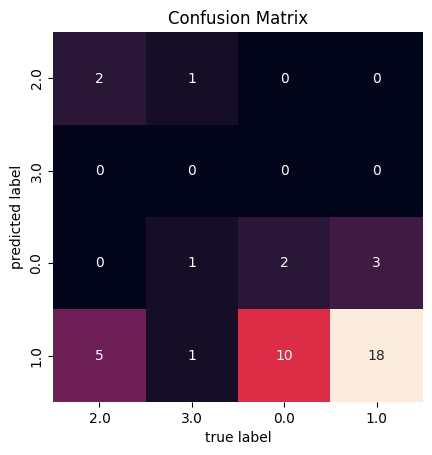

In [45]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


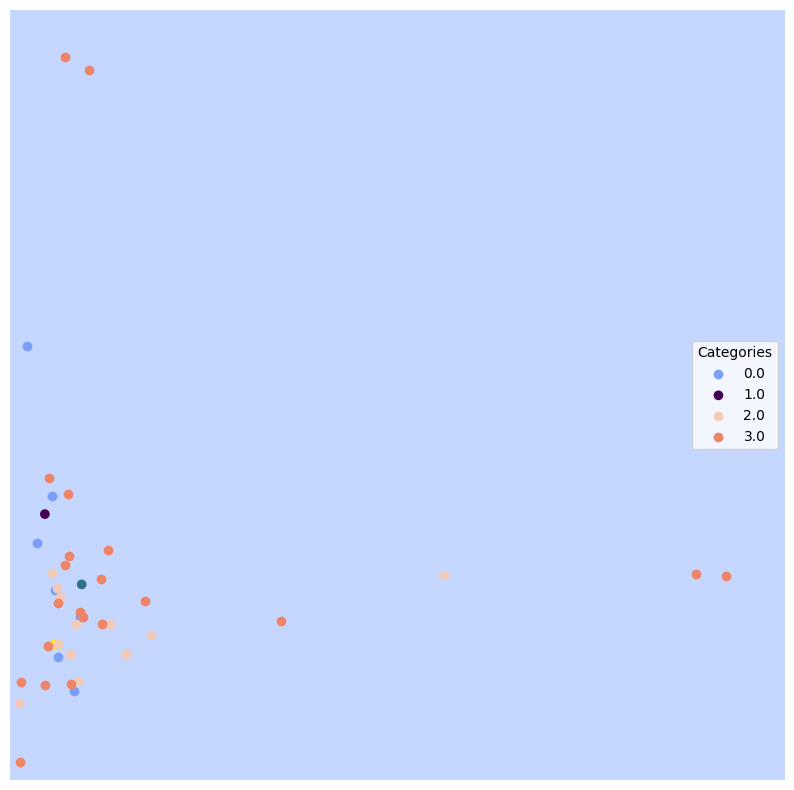

In [46]:
lucem_illud.plotregions(clf_nn, test_data_df)

It seems that the performance of the neural network classifier is relatively bad (similar to that of the k-nearest neighbor) and random forest classifier performs better than it.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


In [ ]:
result = nlp("我喜欢你")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.8317


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6329, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5102, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [47]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,pipeline

In [54]:
model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')
tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True, max_length=512)

In [56]:
topic_dct = {}
for article in news_df['article']:
  topic = text_classification(article)[0]['label']
  if topic in topic_dct.keys():
    topic_dct[topic] += 1
  else:
    topic_dct[topic] = 1
topic_dct

{'mainland China politics': 16,
 'financial news': 83,
 'culture': 68,
 'International news': 16,
 'sports': 22,
 'entertainment': 4,
 'Hong Kong - Macau politics': 5}

Using the topic analysis function provided by transformers, we can easily assign meaningful topic categories to articles. From the result, we can discover that the major topic of articles on this newspaper is about cultural and financial news.